In [1]:
# Bibliotecas
import sys, pandas as pd, numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns, numpy as np, os
from os.path import exists
import pickle 
sys.path.append('../')

from env.RiverProblem import RiverProblem
from rl_utils.VizTools import VizTools

# Modelos
from models.Neutral_VI import Neutral_VI
from models.Neutral_PI import Neutral_PI

from models.ExponentialUtility_RSPI import ExponentialUtility_RSPI
from models.ExponentialUtility_RSVI import ExponentialUtility_RSVI

from models.PieceLinear_RSPI import PieceLinear_RSPI
from models.PieceLinear_RSVI import PieceLinear_RSVI

%load_ext autoreload
%autoreload 2

# Experimentos - 1S2023

|Data|Descritivo|
|--|--|
|03-2023|Primeiros experimentos com confecção de artigo|

---

## Referências

**Exponential**

> 2013 MICAI: Shortest Stochastic Path with Risk Sensitive Evaluation \
> 2016 BRACIS: Extreme Risk Averse Policy for Goal-Directed Risk-Sensitive MDP \
> 2020 BRACIS: Risk Sensitive Stochastic Shortest Path and LogSumExp: from theory to practice

**Piecewise Linear**

> 2020 MICAI: Risk-Sensitive Piecewise-Linear Policy Iteration for SSP-MDP

In [2]:
# ----------------------------------------------
# -- Configurações Iniciais --------------------
# ----------------------------------------------

run_value_iteration = False
run_policy_iteration = False

run_EUF_RSPI = True
run_EUF_RSVI = False

run_PWL_RSPI = False
run_PWL_RSVI = True

# -- Configurações Rio

grid_size = (5, 20)
goal_state = (4, 0)

rp = RiverProblem(grid_size, goal_state, dead_end=False)
block_type = rp.build_block_type()

# -- Configurações River Flow

range_river_flow = [0.7]
epsilon = 0.001

# -- Configuração Exportação
config_reduzida = False
vt = VizTools()

river_flow = range_river_flow[0]

str_red = 'RED_' if config_reduzida else ''
sufixo = f"{str_red}_{river_flow}_T4"
path_export = os.path.join('saidas', f'results_{river_flow}_p-lin_{sufixo}.xlsx')
path_export_ExponentialUtility = os.path.join('saidas', f'results_{river_flow}_RS-ValueIteration_{sufixo}.xlsx')

In [3]:
def run_river_problem(river_flow, model_obj, epsilon=None, vl_lambda=None, discount_factor=None, 
                                     k=None, gamma=None, alpha=None, explogsum=None, _log=False):
    transition_probabilities = rp.build_transition_probabilities(block_type, river_flow=river_flow)

    is_ok, dict_verification = rp._verify_sum_probabilities(transition_probabilities, block_type)
    if not is_ok: print(f'Soma das Probabilidades está válida? {is_ok}')
    
    if epsilon != None and discount_factor != None:
        rnp = model_obj(grid_size, goal_state, transition_probabilities, costs, 
                         num_actions=4, discount_factor=discount_factor, epsilon=epsilon, river_flow=river_flow)
    elif epsilon != None and vl_lambda != None:
        rnp = model_obj(rp, transition_probabilities, costs, vl_lambda,
                         num_actions=4, epsilon=epsilon, river_flow=river_flow, explogsum=explogsum)
    elif epsilon != None and k != None and gamma != None and alpha != None:
        rnp = model_obj(rp, transition_probabilities, costs, k, alpha, gamma,
                         num_actions=4, epsilon=epsilon, river_flow=river_flow)
    
    num_iterations, V, PI = rnp.run_converge()
    if _log: print(f'Número de Iterações: {num_iterations}')
    if _log: print(f'Tempo de Execução: {time}s')
    
    return rnp

In [4]:
# vt.visualize_PI(ExponentialUtility_RSPI, EUF_RSPI[k_exp].PI, grid_size, 4, goal_state, 4, '')

# Value Iteration

In [5]:
# Value Iteration - Configs
if run_value_iteration:
    discount_factor = 0.99
    epsilon = 0.0001

    costs = {0: 1, 1: 1, 2: 1, 3: 1}
    block_type = rp.build_block_type()

In [6]:
# Value Iteration - Run
if run_value_iteration:
    value_iteration_01 = \
    run_river_problem(river_flow=0.1, model_obj=Neutral_VI, epsilon=epsilon, discount_factor=discount_factor)
    value_iteration_05 = \
    run_river_problem(river_flow=0.75, model_obj=Neutral_VI, epsilon=epsilon, discount_factor=discount_factor)
    value_iteration_09 = \
    run_river_problem(river_flow=0.9, model_obj=Neutral_VI, epsilon=epsilon, discount_factor=discount_factor)

In [7]:
# Value Iteration - Displays
if run_value_iteration:
    display(value_iteration_01)
    display(value_iteration_05)
    display(value_iteration_09)

# Policy Iteration

Definimos o algoritmo de Policy Iteration da seguinte forma:

1. Escolhe uma política $\pi_0$ arbitrária;
2. Define $i=0$ como a quantidade de iterações;
3. Para cada iteração, enquanto ($i=0$ ou $\pi_i \neq \pi_{i-1}$) faça: \
    3.1. Policy Evaluation: obtém o valor da política atual $\pi_i$ para cada $s \in S$ resolvendo o seguinte sistema de equações: \
    $$V^{(\pi_i)}(s)=r(s,\pi_i(s))+\sum_{s'\in S} T(s, \pi_i(s), s') V^{\pi_i}(s') \forall s \in S$$
    3.2. Policy Improvement: melhora a política atual realizando uma atualização para todo $s \in S$: \
    $$\pi_{i+1}(s)=\text{argmax}_{a \in A_s}[r(s,a)+\sum_{s'\in S} T(s, a, s') V^{\pi_i}(s')]$$

In [8]:
# Policy Iteration - Configs
if run_policy_iteration:
    discount_factor = 0.99
    epsilon = 0.001
    costs = {0: 1, 1: 1, 2: 1, 3: 1}

In [9]:
# Policy Iteration - Run
if run_policy_iteration:
    policy_iteration_01 = \
    run_river_problem(river_flow=0.1, model_obj=Neutral_PI, epsilon=epsilon, discount_factor=discount_factor)
    policy_iteration_05 = \
    run_river_problem(river_flow=0.5, model_obj=Neutral_PI, epsilon=epsilon, discount_factor=discount_factor)
    policy_iteration_09 = \
    run_river_problem(river_flow=0.9, model_obj=Neutral_PI, epsilon=epsilon, discount_factor=discount_factor)

In [10]:
# Policy Iteration - Displays
if run_policy_iteration:
    display(policy_iteration_01)
    display(policy_iteration_05)
    display(policy_iteration_09)

# Value Iteration - Exponential Utility Function for RS-MDP

Definimos o algoritmo de Risk Sensitive MDP da seguinte forma:

1. Escolhe uma política $\pi_0$ arbitrária;
2. Define $i=0$ como a quantidade de iterações;
3. Para cada iteração, enquanto ($i=0$ ou $\pi_i \neq \pi_{i-1}$) faça: \
    3.1. Policy Evaluation: obtém o valor da política atual $\pi_i$ para cada $s \in S$ resolvendo o seguinte sistema de equações: \
    $$V^{\pi_i}(s_G)=-\text{sign}(\lambda)$$
    $$V^{(\pi_i)}(s)=\text{exp}(-\lambda r(s,\pi_i(s)))\sum_{s'\in S} T(s, \pi_i(s), s') V^{\pi_i}(s') \forall s \neq s_G \in S$$
    3.2. Policy Improvement: melhora a política atual realizando uma atualização para todo $s \in S$: \
    $$\pi_{i+1}(s)=\text{argmax}_{a \in A_s}[\text{exp}(-\lambda r(s,a))\sum_{s'\in S} T(s, a, s') V^{\pi_i}(s')]$$
    
    
When λ < 0 (risk prone) and the policy π is proper, then π is also λ-feasible. However, this is not guaranteed for all policies when λ > 0 (risk averse). Given a GD-RSMDP, no result exists on how to determine the set of λ > 0 such that exists a λ-feasible policy.


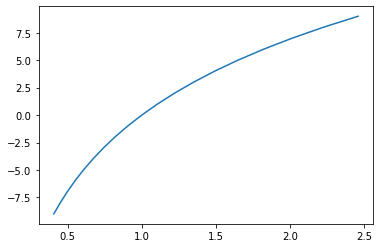

In [11]:
# Exponential Lambda
plt.plot([np.exp(v/10) for v in np.arange(-9, 10, 1)], np.arange(-9, 10, 1))

In [12]:
# Exponential Utility Function for RS-MDP-VI - Configs
if run_EUF_RSVI:
    EUF_RSVI = {}
    
    if config_reduzida:
        range_lambda = [-0.2, 0.5]
    else:
        range_lambda = [-0.2, -0.15, -0.1, -0.05, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 
                        0.6, 0.7, 0.8, 0.9, 1]
    
    costs = {0: 1, 1: 1, 2: 1, 3: 1}

In [13]:
# Exponential Utility Function for RS-MDP-VI - Run
if run_EUF_RSVI:
    for river_flow in range_river_flow:
        for vl_lambda in range_lambda:
            print(f'Processando: RF [{river_flow}] Lambda [{vl_lambda}]')
            EUF_RSVI[(river_flow, vl_lambda)] = \
                run_river_problem(river_flow=river_flow, model_obj=ExponentialUtility_RSVI, 
                vl_lambda=vl_lambda, epsilon=epsilon)

In [14]:
# Exponential Utility Function for RS-MDP-VI - Keys
if run_EUF_RSVI:
    display(EUF_RSVI.keys())

In [15]:
# Exponential Utility Function for RS-MDP-VI - Display
if run_EUF_RSVI: 
    display(EUF_RSVI)

# Exponential Utility Function for RS-MDP

Definimos o algoritmo de Risk Sensitive MDP da seguinte forma:

1. Escolhe uma política $\pi_0$ arbitrária;
2. Define $i=0$ como a quantidade de iterações;
3. Para cada iteração, enquanto ($i=0$ ou $\pi_i \neq \pi_{i-1}$) faça: \
    3.1. Policy Evaluation: obtém o valor da política atual $\pi_i$ para cada $s \in S$ resolvendo o seguinte sistema de equações: \
    $$V^{\pi_i}(s_G)=-\text{sign}(\lambda)$$
    $$V^{(\pi_i)}(s)=\text{exp}(\lambda r(s,\pi_i(s)))\sum_{s'\in S} T(s, \pi_i(s), s') V^{\pi_i}(s') \forall s \neq s_G \in S$$
    3.2. Policy Improvement: melhora a política atual realizando uma atualização para todo $s \in S$: \
    $$\pi_{i+1}(s)=\text{argmax}_{a \in A_s}[\text{exp}(\lambda r(s,a))\sum_{s'\in S} T(s, a, s') V^{\pi_i}(s')]$$
    
    
When λ < 0 (risk prone) and the policy π is proper, then π is also λ-feasible. However, this is not guaranteed for all policies when λ > 0 (risk averse). Given a GD-RSMDP, no result exists on how to determine the set of λ > 0 such that exists a λ-feasible policy.


In [16]:
# Exponential Utility Function for RSPI - Configs
if run_EUF_RSPI:
    EUF_RSPI = {}
    explogsum = True
    
    if config_reduzida:
        range_lambda = [-0.2, 0.5]
    else:
        range_lambda = [-0.5, -0.4, -0.3, -0.2, -0.15, -0.1, -0.075, -0.05, -0.01, -0.001, 
                        0.001, 0.01, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 
                        0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1]
        
    range_lambda = [0]
    
    costs = {0: 1, 1: 1, 2: 1, 3: 1}

In [17]:
# Exponential Utility Function for RS-MDP - Run
if run_EUF_RSPI:
    for river_flow in range_river_flow:
        for vl_lambda in range_lambda:
            print(f'Processando: RF [{river_flow}] Lambda [{vl_lambda}]')
            EUF_RSPI[(river_flow, vl_lambda)] = \
                run_river_problem(river_flow=river_flow, model_obj=ExponentialUtility_RSPI, 
                vl_lambda=vl_lambda, epsilon=epsilon, explogsum=explogsum)

Processando: RF [0.7] Lambda [0]


In [18]:
# Exponential Utility Function for RS-MDP - Keys
if run_EUF_RSPI:
    display(EUF_RSPI.keys())

dict_keys([(0.7, 0)])

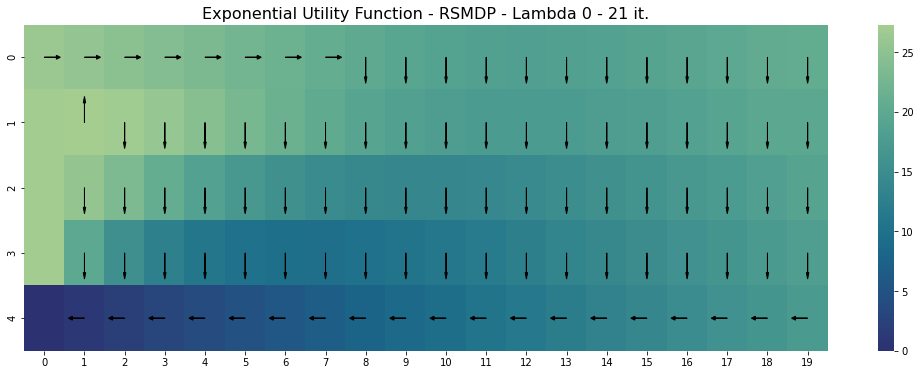

{(0.7,
  0): RiverProblem - 
 Lambda: 0 
 Epsilon: 0.001 }

In [19]:
# Exponential Utility Function for RS-MDP - Display
if run_EUF_RSPI: 
    display(EUF_RSPI)

# PieceLinear - RSVI (Risk Sensitive Value Iteration)

Define-se uma transformação por partes linear $X^{(k)}$ que depende de um parâmetro $x$ (diferença temporal) seja positiva ou não e um fator de risco $k$:

$$X^{(k)}(x)= \left\{ \begin{array} & (1-k)x & \text{, if x < 0,} \\ (1+k)x & \text{, otherwise.} \end{array} \right. $$

---

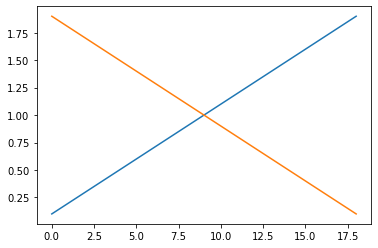

In [20]:
# Piecewise Linear
if run_PWL_RSVI:
    p = plt.plot([(1 - v/10) if 1 < 0 else (1 + v/10) for v in np.arange(-9, 10, 1)])
    p = plt.plot([(1 - v/10) if -1 < 0 else (1 + v/10) for v in np.arange(-9, 10, 1)])

In [21]:
# Piecewise-Linear RSVI - Configs
if run_PWL_RSVI:
    PWL_RSVI = {}
    
    if config_reduzida:
        range_k     = [-0.9, 0.9]
    else:
        range_k     = [-0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 
                       0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.325, 0.35, 0.375, 0.4, 0.45, 
                       0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
    
    gamma       = 1
    range_alpha = [np.round(1/(1+abs(k)), 2) for k in range_k]
    
    costs = {0: 1, 1: 1, 2: 1, 3: 1}

In [22]:
print(range_k)

[-0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.325, 0.35, 0.375, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]


In [23]:
# Piecewise-Linear RSVI - Run
if run_PWL_RSVI:
    for river_flow in range_river_flow:
        for i in range(0, len(range_k)):
            print(f'Processando: RF [{river_flow}] K [{range_k[i]}] Alpha [{range_alpha[i]}]')
            PWL_RSVI[(river_flow, range_k[i], gamma, range_alpha[i])] = \
                run_river_problem(river_flow=river_flow, model_obj=PieceLinear_RSVI,
                gamma=gamma, k=range_k[i], alpha=range_alpha[i], epsilon=epsilon)

Processando: RF [0.7] K [-0.9] Alpha [0.53]
Processando: RF [0.7] K [-0.8] Alpha [0.56]
Processando: RF [0.7] K [-0.7] Alpha [0.59]
Processando: RF [0.7] K [-0.6] Alpha [0.62]
Processando: RF [0.7] K [-0.5] Alpha [0.67]
Processando: RF [0.7] K [-0.4] Alpha [0.71]
Processando: RF [0.7] K [-0.3] Alpha [0.77]
Processando: RF [0.7] K [-0.2] Alpha [0.83]
Processando: RF [0.7] K [-0.1] Alpha [0.91]
Processando: RF [0.7] K [0.0] Alpha [1.0]
Processando: RF [0.7] K [0.05] Alpha [0.95]
Processando: RF [0.7] K [0.1] Alpha [0.91]
Processando: RF [0.7] K [0.15] Alpha [0.87]
Processando: RF [0.7] K [0.2] Alpha [0.83]
Processando: RF [0.7] K [0.25] Alpha [0.8]
Processando: RF [0.7] K [0.3] Alpha [0.77]
Processando: RF [0.7] K [0.325] Alpha [0.75]
Processando: RF [0.7] K [0.35] Alpha [0.74]
Processando: RF [0.7] K [0.375] Alpha [0.73]
Processando: RF [0.7] K [0.4] Alpha [0.71]
Processando: RF [0.7] K [0.45] Alpha [0.69]
Processando: RF [0.7] K [0.5] Alpha [0.67]
Processando: RF [0.7] K [0.6] Alpha [0

In [24]:
# Piecewise-Linear RSVI - Run
if run_PWL_RSVI:
    PWL_RSVI.keys()

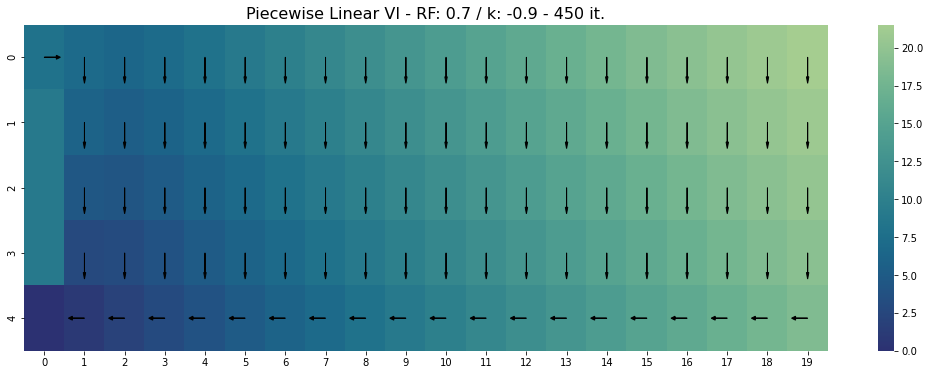

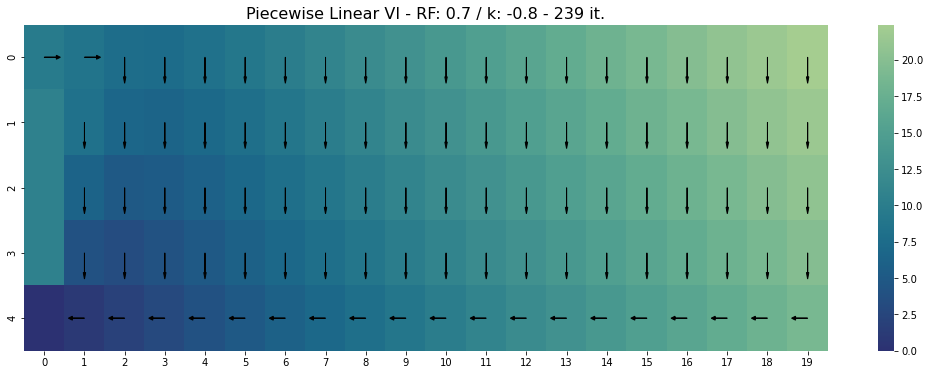

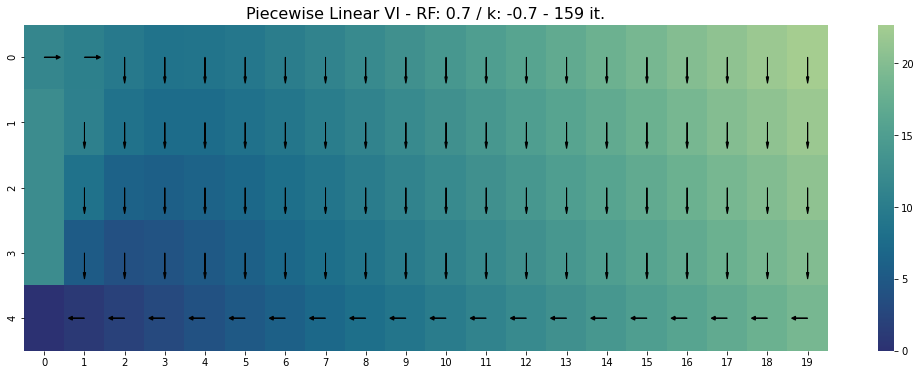

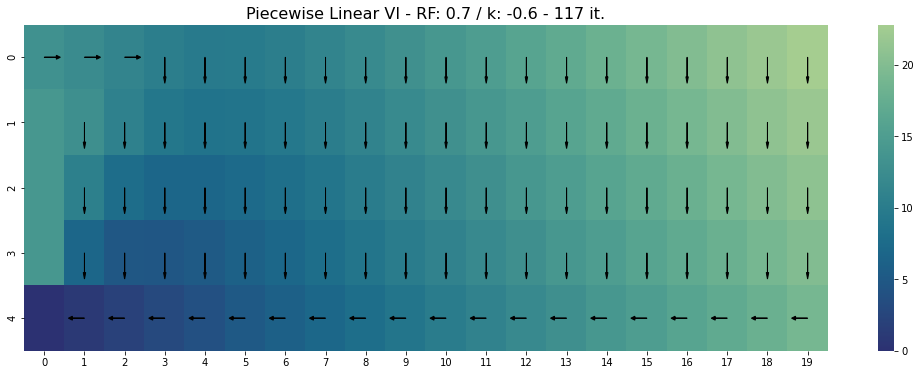

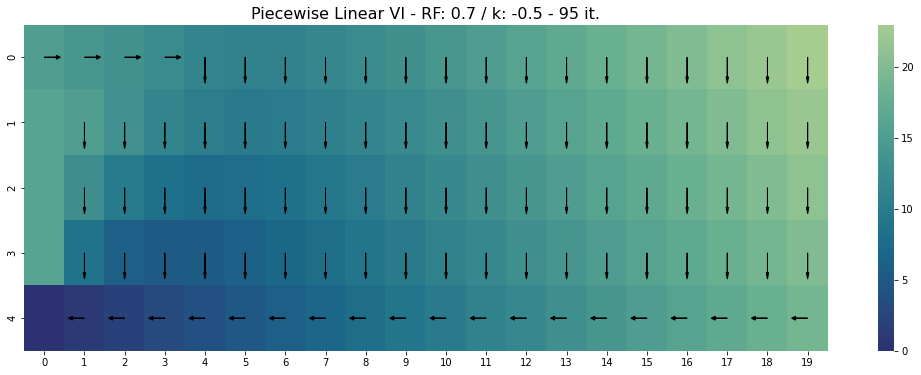

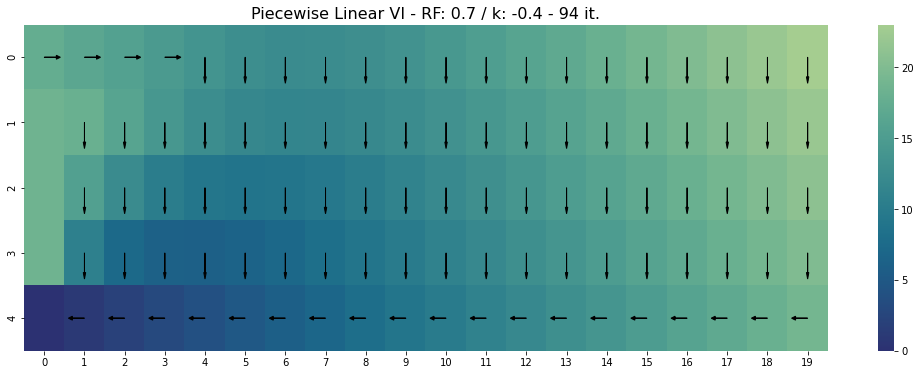

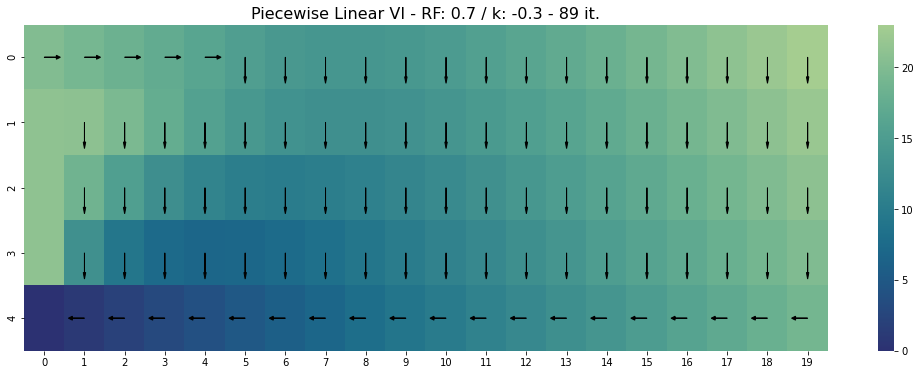

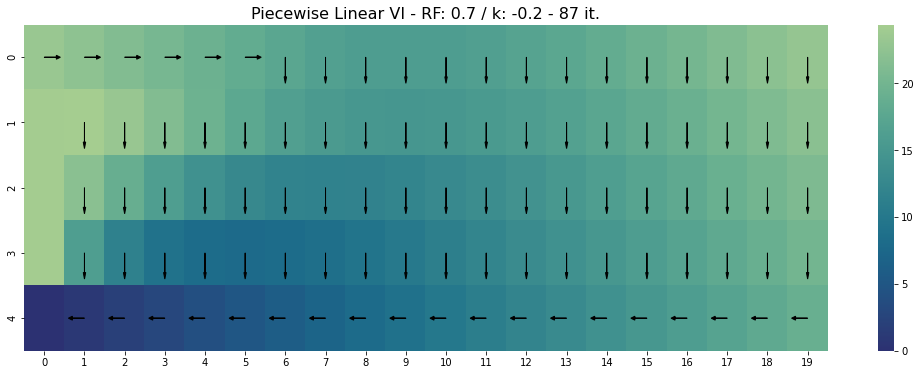

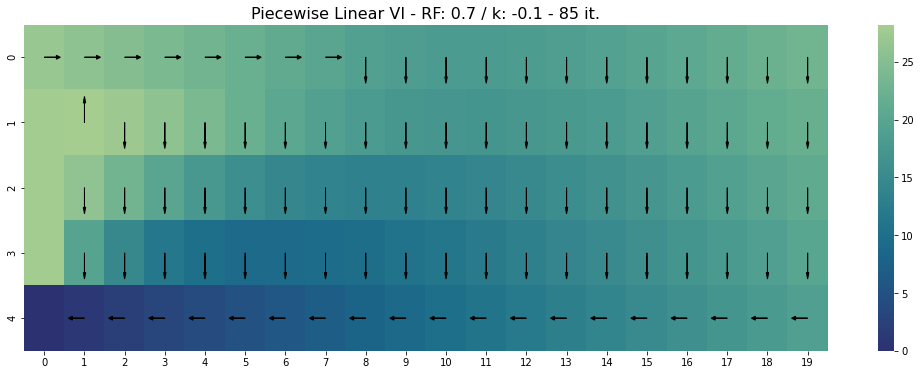

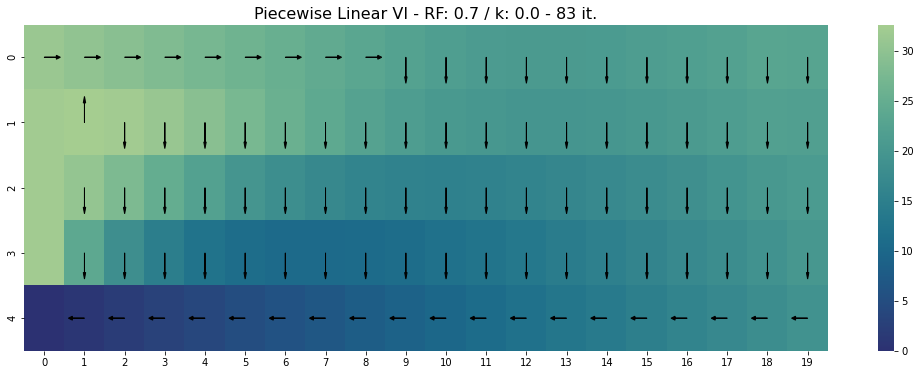

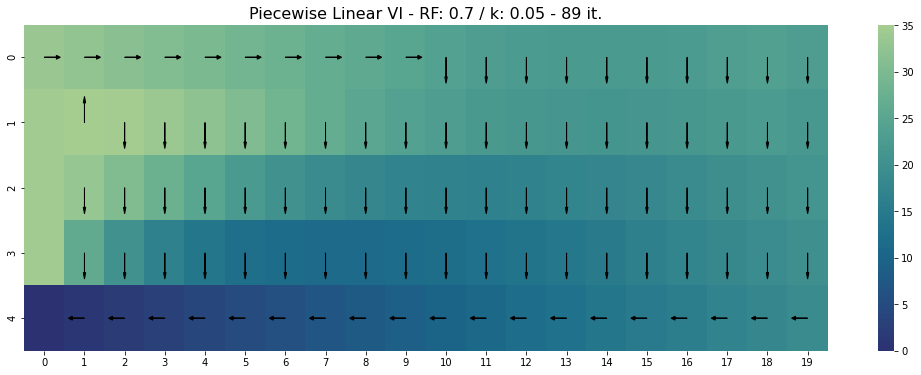

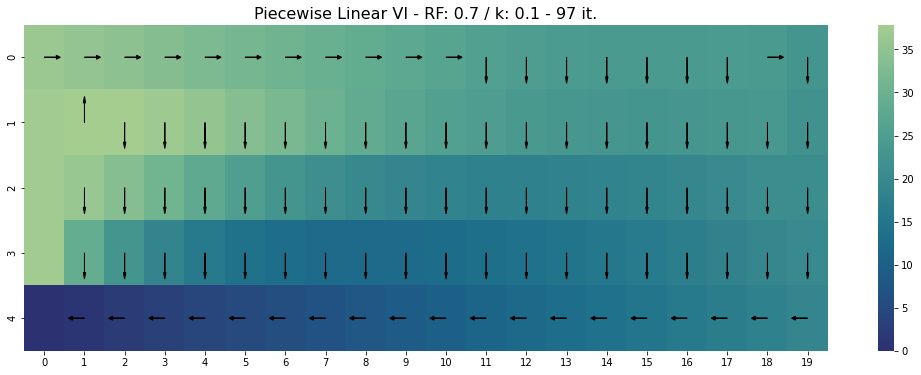

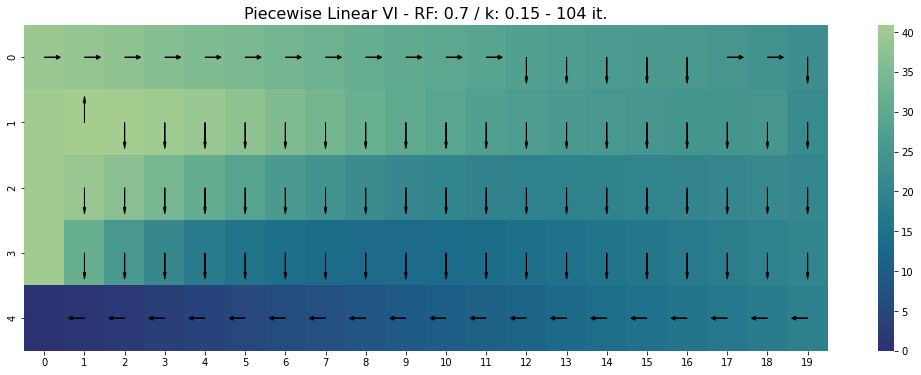

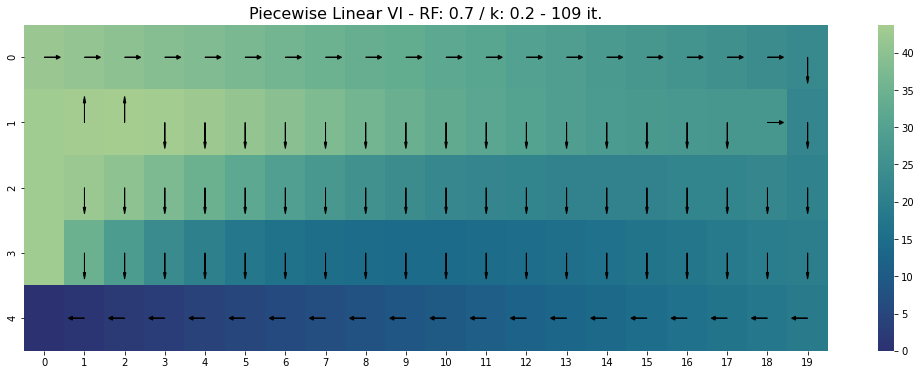

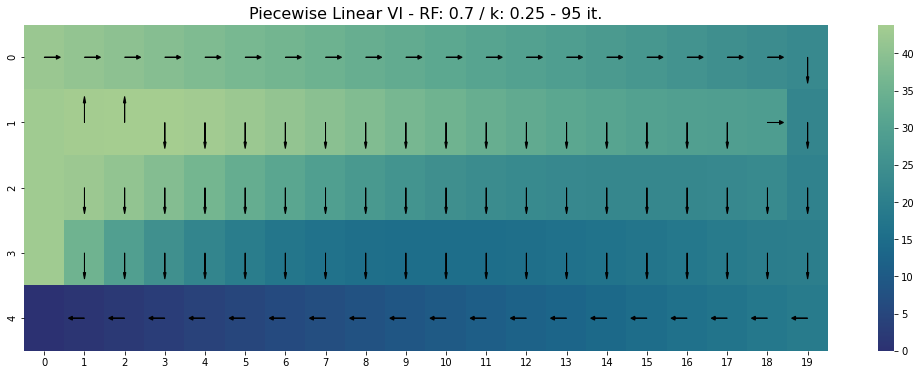

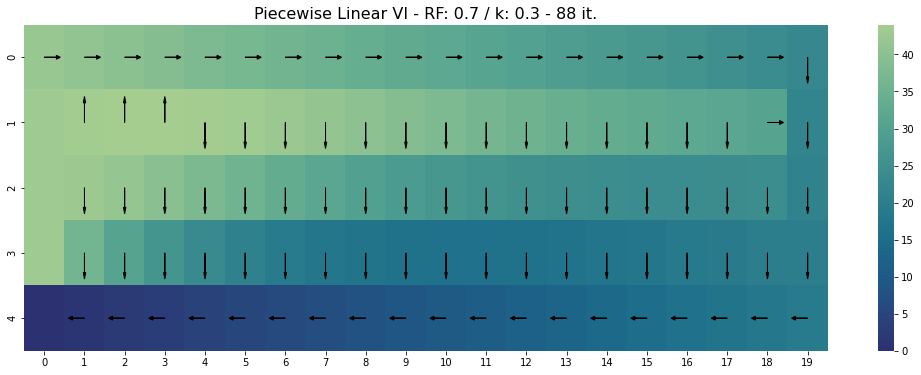

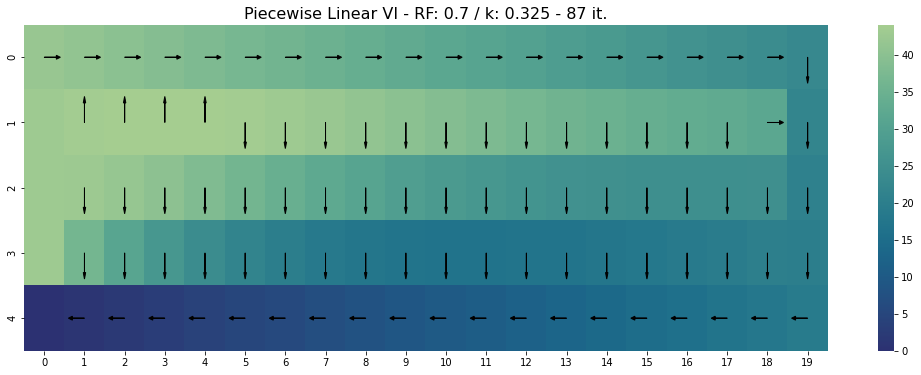

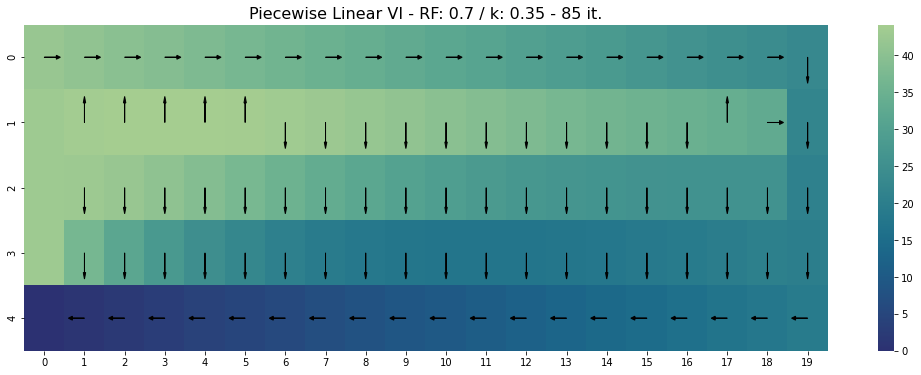

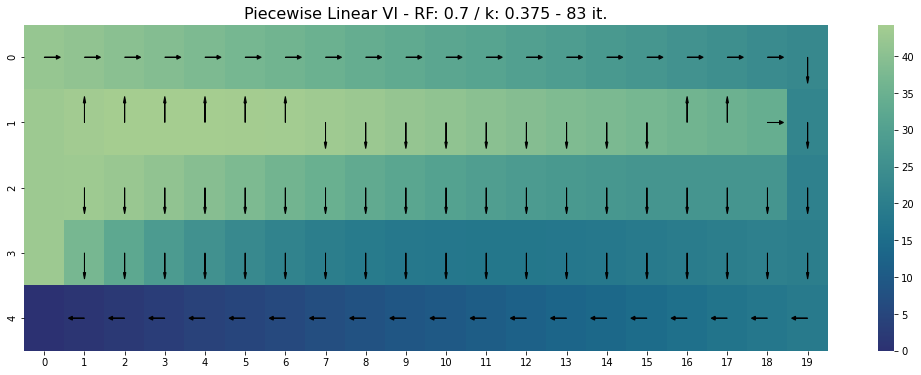

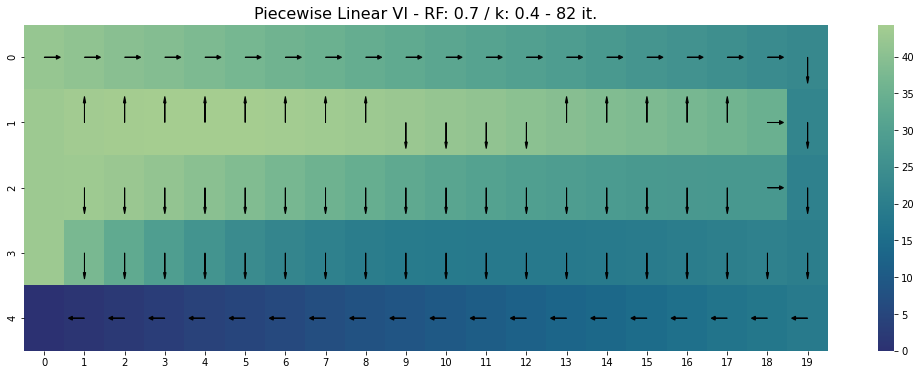

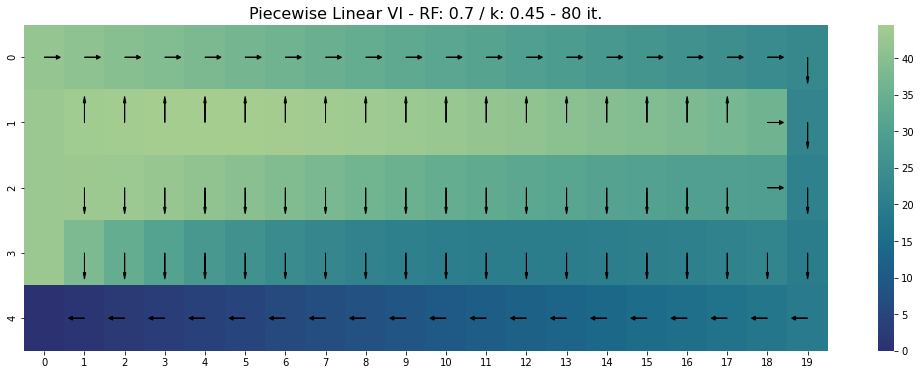

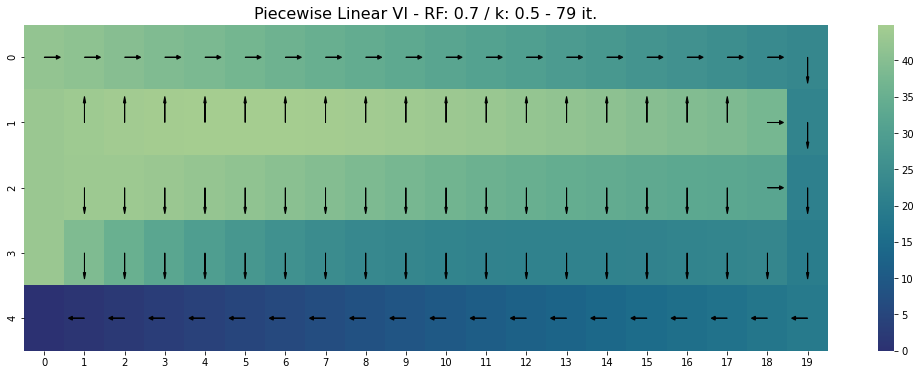

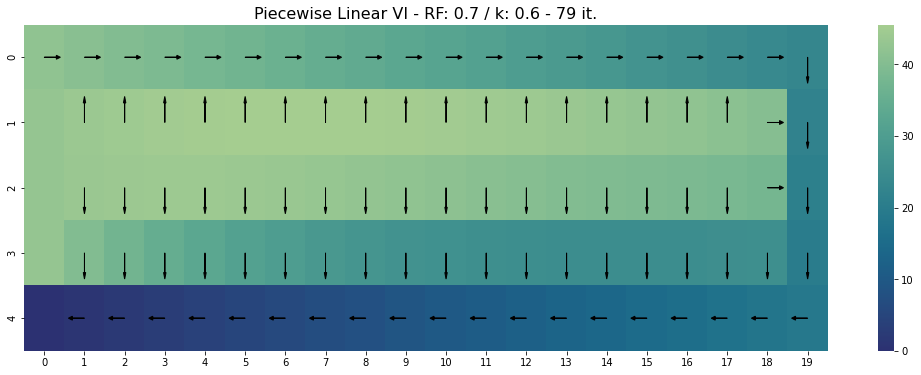

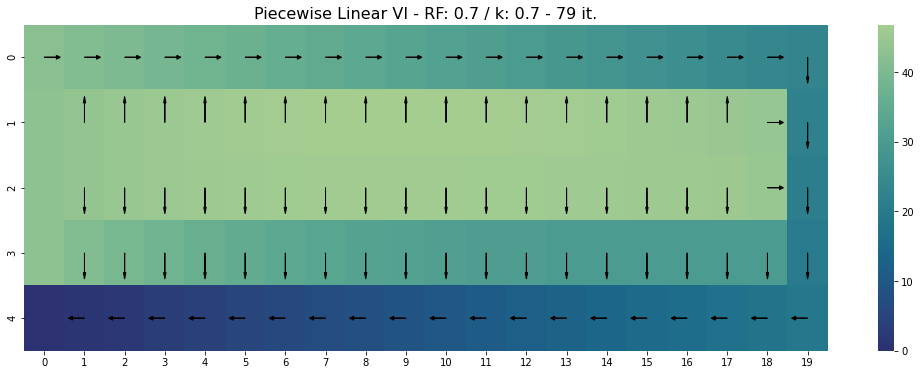

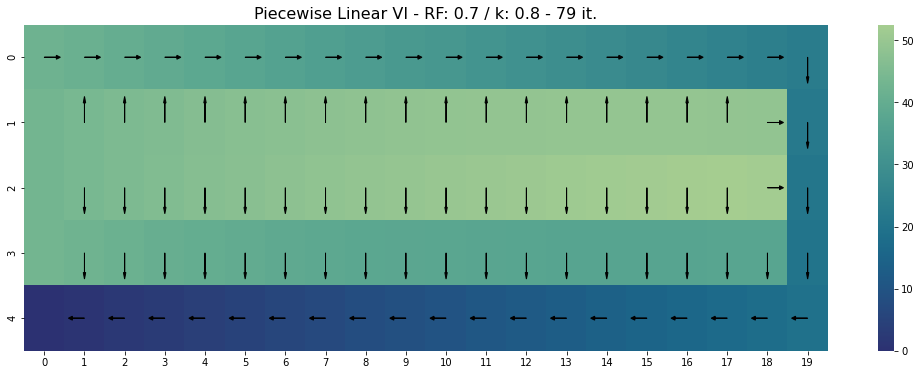

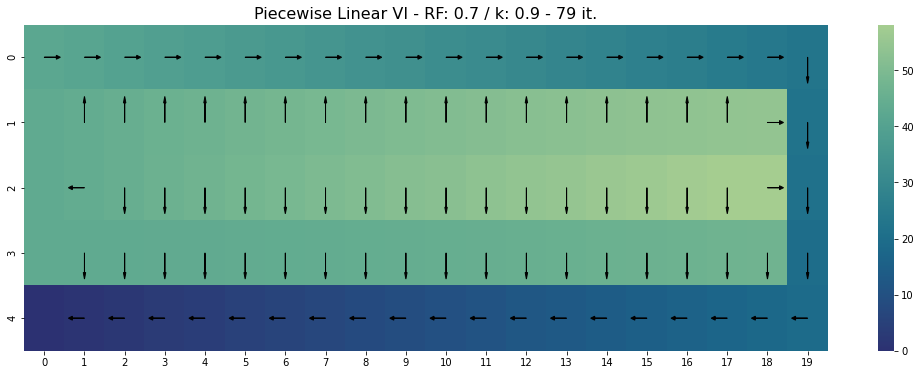

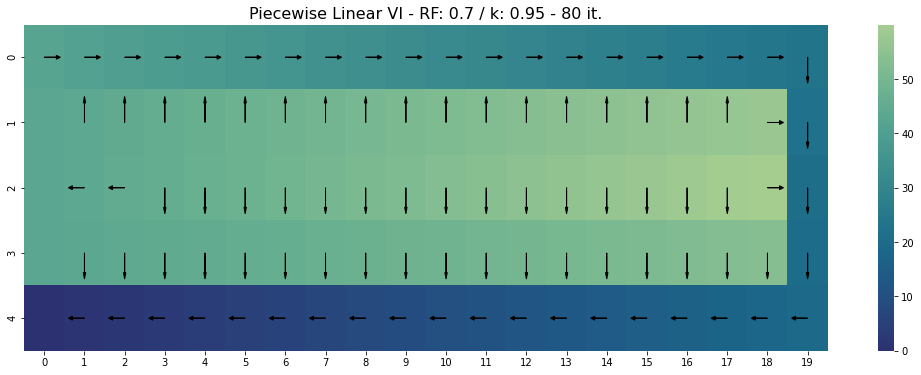

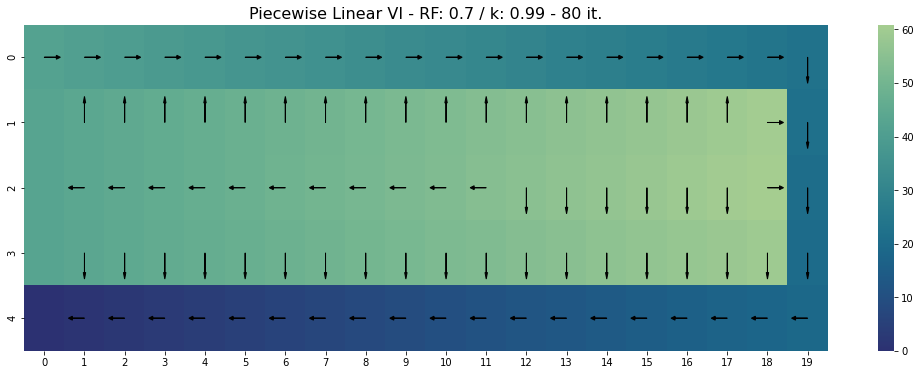

{(0.7,
  -0.9,
  1,
  0.53): > Visualização da Política 
 k: -0.9 
 alpha: 0.53 
 gamma: 1 ,
 (0.7,
  -0.8,
  1,
  0.56): > Visualização da Política 
 k: -0.8 
 alpha: 0.56 
 gamma: 1 ,
 (0.7,
  -0.7,
  1,
  0.59): > Visualização da Política 
 k: -0.7 
 alpha: 0.59 
 gamma: 1 ,
 (0.7,
  -0.6,
  1,
  0.62): > Visualização da Política 
 k: -0.6 
 alpha: 0.62 
 gamma: 1 ,
 (0.7,
  -0.5,
  1,
  0.67): > Visualização da Política 
 k: -0.5 
 alpha: 0.67 
 gamma: 1 ,
 (0.7,
  -0.4,
  1,
  0.71): > Visualização da Política 
 k: -0.4 
 alpha: 0.71 
 gamma: 1 ,
 (0.7,
  -0.3,
  1,
  0.77): > Visualização da Política 
 k: -0.3 
 alpha: 0.77 
 gamma: 1 ,
 (0.7,
  -0.2,
  1,
  0.83): > Visualização da Política 
 k: -0.2 
 alpha: 0.83 
 gamma: 1 ,
 (0.7,
  -0.1,
  1,
  0.91): > Visualização da Política 
 k: -0.1 
 alpha: 0.91 
 gamma: 1 ,
 (0.7,
  0.0,
  1,
  1.0): > Visualização da Política 
 k: 0.0 
 alpha: 1.0 
 gamma: 1 ,
 (0.7,
  0.05,
  1,
  0.95): > Visualização da Política 
 k: 0.05 
 alpha:

In [25]:
# Piecewise-Linear RSVI - View
if run_PWL_RSVI:
    display(PWL_RSVI)

# PieceLinear - RSPI (Risk Sensitive Policy Iteration)

Define-se uma transformação por partes linear $X^{(k)}$ que depende de um parâmetro $x$ (diferença temporal) seja positiva ou não e um fator de risco $k$:

$$X^{(k)}(x)= \left\{ \begin{array} & (1-k)x & \text{, if x < 0,} \\ (1+k)x & \text{, otherwise.} \end{array} \right. $$

1. Escolhe uma política $\pi_0$ arbitrária;
2. Define $i=0$ como a quantidade de iterações;
3. Para cada iteração, enquanto ($i=0$ ou $\pi_i \neq \pi_{i-1}$) faça: \
    3.1. Policy Evaluation: obtém o valor da política atual $\pi_i$ para cada $s \in S$ resolvendo o seguinte sistema de equações: \
    $$
    O^{\pi}_{\alpha k}[V](s) = V(s) + \alpha \sum_{s'\in S} P(s'|s, \pi(s)) X^{(k)}(C(s,\pi(s),s')+\gamma V(s') - V(s))    
    $$
    3.2. Policy Improvement: melhora a política atual realizando uma atualização para todo $s \in S$: \
    $$
    \pi'(s)=\text{argmin}_{a\in A}\sum_{s'\in S} P(s'|s, a) X^{(k)}(C(s,a,s')+\gamma V(s') - V^\pi_k(s))
    $$

In [26]:
# Piecewise-Linear RSPI - Configs
if run_PWL_RSPI:
    PWL_RSPI = {}
    
    range_river_flow = [0.2] #[rf/10 for rf in range(1, 10)]
    range_k     = [v/10 for v in range(-9, 10)]
    gamma       = 1
    range_alpha = [np.round(1/(1+abs(k)), 2) for k in range_k]
    
    costs = {0: 1, 1: 1, 2: 1, 3: 1}

In [27]:
# Piecewise-Linear RSPI - Run
if run_PWL_RSPI:
    for river_flow in range_river_flow:
        for i in range(0, len(range_k)):
            print(f'Processando: RF [{river_flow}] K [{range_k[i]}] Alpha [{range_alpha[i]}]')
            PWL_RSPI[(river_flow, range_k[i], gamma, range_alpha[i])] = \
                run_river_problem(river_flow=river_flow, model_obj=PieceLinear_RSPI,
                gamma=gamma, k=range_k[i], alpha=range_alpha[i], epsilon=epsilon)

In [28]:
# Piecewise-Linear RSPI - Keys
if run_PWL_RSPI:
    print(PWL_RSPI.keys())

In [29]:
# Piecewise-Linear RSPI - View
# PWL_RSPI[(0.2, -0.8, 1, 0.56)]
if run_PWL_RSPI:
    display(PWL_RSPI)

# Comparando Políticas Geradas



## Define funções

In [30]:
def get_PLIN(model, river_flow, vl_k, vl_gamma, vl_alpha, PI):
    
    transition_probabilities = rp.build_transition_probabilities(block_type, river_flow=river_flow)
    m = PieceLinear_RSVI(rp, transition_probabilities, costs, vl_k, vl_alpha, vl_gamma,
                         num_actions=4, epsilon=epsilon, river_flow=river_flow)
    return m.calculate_value_for_policy(PI, vl_k)

## PLIN(env, K, pi) -> R

In [31]:
if not os.path.isfile(path_export):
    # Captura valores gerados pelas políticas do algoritmo Linear
    # e aplica na função valor linear
    P_VALUE_LIN = {}

    for k in PWL_RSVI.keys():
        river_flow = k[0]
        vl_k = k[1]
        vl_gamma = k[2]
        vl_alpha = k[3]

        print(f'Getting Expected Value for [{river_flow}/{vl_k}].', end='\r')

        if not str(river_flow) in P_VALUE_LIN.keys():
            P_VALUE_LIN[str(river_flow)] = {}

        P_VALUE_LIN[str(river_flow)][str(vl_k)] = \
            get_PLIN(PieceLinear_RSVI, river_flow, vl_k, vl_gamma, vl_alpha, PWL_RSVI[k].PI)

    display(P_VALUE_LIN)

{'0.7': {'-0.9': 1171.26638441501,
  '-0.8': 1198.3148069157317,
  '-0.7': 1225.5014755894258,
  '-0.6': 1257.1841090073108,
  '-0.5': 1301.2180670536782,
  '-0.4': 1359.5227139532049,
  '-0.3': 1436.429988717768,
  '-0.2': 1542.1844639965652,
  '-0.1': 1687.2043417548884,
  '0.0': 1885.9331039111883,
  '0.05': 2012.4553898052238,
  '0.1': 2160.7747141364835,
  '0.15': 2332.8778226040804,
  '0.2': 2477.766654972357,
  '0.25': 2551.150493787248,
  '0.3': 2642.116227771232,
  '0.325': 2667.953364865445,
  '0.35': 2707.9997331547243,
  '0.375': 2764.503546907616,
  '0.4': 2786.4401297529785,
  '0.45': 2866.452818252773,
  '0.5': 2968.0210383637277,
  '0.6': 3090.4837120478815,
  '0.7': 3371.8992492685798,
  '0.8': 3802.964343780348,
  '0.9': 4001.074303215307,
  '0.95': 3765.62506267283,
  '0.99': 3846.6315195686375}}

In [32]:
if not os.path.isfile(path_export):
    # Captura valores gerados pelas políticas do algoritmo exponencial
    # e aplica na função valor linear
    _debug = False
    P_VALUE_LIN_EXP = {}
    P_VALUE_LIN_EXP_MAX = {}
    LAMBDA_MAX = {}

    for k in PWL_RSVI.keys():
        river_flow = k[0]
        vl_k = k[1]
        vl_gamma = k[2]
        vl_alpha = k[3]

        print(f'>> Getting Expected Value for [{river_flow}/{vl_k}].')

        if not str(river_flow) in P_VALUE_LIN_EXP.keys():
            P_VALUE_LIN_EXP[str(river_flow)] = {}
            P_VALUE_LIN_EXP_MAX[str(river_flow)] = {}
            LAMBDA_MAX[str(river_flow)] = {}

        max_lambda, last_dif = np.inf, np.inf
#         for k_exp in EUF_RSVI.keys():
        for k_exp in EUF_RSPI.keys():
            if not str(vl_k) in P_VALUE_LIN_EXP[str(river_flow)].keys():
                P_VALUE_LIN_EXP[str(river_flow)][str(vl_k)] = {}

            vl_lambda = k_exp[1]
            print(f'> Getting Expected Value for [{river_flow}/{vl_k}/{vl_lambda}].')

            P_VALUE_LIN_EXP[str(river_flow)][str(vl_k)][str(vl_lambda)] = \
                get_PLIN(PieceLinear_RSVI, river_flow, vl_k, vl_gamma, vl_alpha, EUF_RSPI[k_exp].PI)

            VALUE_LIN_EXP = P_VALUE_LIN_EXP[str(river_flow)][str(vl_k)][str(vl_lambda)]
            VALUE_LIN = P_VALUE_LIN[str(river_flow)][str(vl_k)]
            dif = abs(VALUE_LIN_EXP - VALUE_LIN)
            if _debug: print(f'~ DEBUG - LIN_EXP: {VALUE_LIN_EXP} / LIN: {VALUE_LIN}')

            if dif < last_dif:
                max_lambda = vl_lambda
                last_dif = dif

            if _debug: print(f'~ DEBUG - Dif: {dif} / Last Dif: {last_dif} / Lambda Max: {max_lambda}')

        P_VALUE_LIN_EXP_MAX[str(river_flow)][str(vl_k)] = P_VALUE_LIN_EXP[str(river_flow)][str(vl_k)][str(max_lambda)]
        LAMBDA_MAX[str(river_flow)][str(vl_k)] = max_lambda

    display(P_VALUE_LIN_EXP_MAX)

>> Getting Expected Value for [0.7/-0.9].
> Getting Expected Value for [0.7/-0.9/0].
>> Getting Expected Value for [0.7/-0.8].
> Getting Expected Value for [0.7/-0.8/0].
>> Getting Expected Value for [0.7/-0.7].
> Getting Expected Value for [0.7/-0.7/0].
>> Getting Expected Value for [0.7/-0.6].
> Getting Expected Value for [0.7/-0.6/0].
>> Getting Expected Value for [0.7/-0.5].
> Getting Expected Value for [0.7/-0.5/0].
>> Getting Expected Value for [0.7/-0.4].
> Getting Expected Value for [0.7/-0.4/0].
>> Getting Expected Value for [0.7/-0.3].
> Getting Expected Value for [0.7/-0.3/0].
>> Getting Expected Value for [0.7/-0.2].
> Getting Expected Value for [0.7/-0.2/0].
>> Getting Expected Value for [0.7/-0.1].
> Getting Expected Value for [0.7/-0.1/0].
>> Getting Expected Value for [0.7/0.0].
> Getting Expected Value for [0.7/0.0/0].
>> Getting Expected Value for [0.7/0.05].
> Getting Expected Value for [0.7/0.05/0].
>> Getting Expected Value for [0.7/0.1].
> Getting Expected Value f

{'0.7': {'-0.9': 1288.9196635526619,
  '-0.8': 1312.7041221648894,
  '-0.7': 1330.4897543024754,
  '-0.6': 1350.767554794188,
  '-0.5': 1377.2651512258383,
  '-0.4': 1415.4921219161974,
  '-0.3': 1472.24063193269,
  '-0.2': 1557.1990373600458,
  '-0.1': 1687.4857994325519,
  '0.0': 1892.6727594286685,
  '0.05': 2034.345379096719,
  '0.1': 2212.015984502691,
  '0.15': 2443.656681079898,
  '0.2': 2741.160648703495,
  '0.25': 3130.448955329492,
  '0.3': 3644.669979914557,
  '0.325': 3963.296433198333,
  '0.35': 4336.52665650205,
  '0.375': 4768.153787555742,
  '0.4': 5272.032150206679,
  '0.45': 6575.620379144082,
  '0.5': 8418.337630815035,
  '0.6': 14912.77551357872,
  '0.7': 29434.736865721043,
  '0.8': 60111.4753532577,
  '0.9': 100332.0405467139,
  '0.95': 108966.09450463786,
  '0.99': 114517.16268520242}}

### Curva dos Resultados

In [33]:
def build_dataframe_p_value(dict_v, nm_model, col='K'):
    df = pd.DataFrame(dict_v).reset_index().rename(columns={'index': col})
    df[col] = pd.to_numeric(df[col])
    df = df.sort_values(col)
    
    cols = []
    for c in df.columns:
        if c != col:
            cols.append(f'{nm_model}_{c}')
        else:
            cols.append(c)
        
    df.columns = cols
    return df

In [34]:
print(f'Verificando caminho {path_export}')
if os.path.isfile(path_export):
    df_LIN_EXP = pd.read_excel(path_export).drop('Unnamed: 0', axis=1)
else:
    df_LIN_EXP = None
    
if df_LIN_EXP is None:
    df_VALUE_LIN = build_dataframe_p_value(P_VALUE_LIN, 'LIN')
    df_VALUE_LIN_EXP = build_dataframe_p_value(P_VALUE_LIN_EXP_MAX, 'EXP')
    df_LAMBDA_MAX = build_dataframe_p_value(LAMBDA_MAX, 'LAMBDA_MAX')

    df_LIN_EXP = df_VALUE_LIN.merge(df_VALUE_LIN_EXP, on='K')
    df_LIN_EXP = df_LIN_EXP.merge(df_LAMBDA_MAX, on='K')
    df_LIN_EXP.to_excel(path_export)

df_LIN_EXP[f'DIF_EXP_{str(river_flow)}'] = 1 + (df_LIN_EXP[f'LIN_{str(river_flow)}'] - \
              df_LIN_EXP[f'EXP_{str(river_flow)}'])/df_LIN_EXP[f'LIN_{str(river_flow)}']
df_LIN_EXP

Verificando caminho saidas\results_0.7_p-lin__0.7_T4.xlsx


,K,LIN_0.7,EXP_0.7,LAMBDA_MAX_0.7,DIF_EXP_0.7
0,-0.900,1171.266384,1288.919664,0,0.899550
1,-0.800,1198.314807,1312.704122,0,0.904542
2,-0.700,1225.501476,1330.489754,0,0.914330
3,-0.600,1257.184109,1350.767555,0,0.925561
4,-0.500,1301.218067,1377.265151,0,0.941557
5,-0.400,1359.522714,1415.492122,0,0.958832
6,-0.300,1436.429989,1472.240632,0,0.975070
7,-0.200,1542.184464,1557.199037,0,0.990264
8,-0.100,1687.204342,1687.485799,0,0.999833
9,0.000,1885.933104,1892.672759,0,0.996426


In [35]:
def g_comparing_values(df, river_flow, nm_metrica, valor1, valor2):
    figure(figsize=(12, 7), dpi=80)
    df_plt = df[[nm_metrica, f'{valor1}_{str(river_flow)}', f'{valor2}_{str(river_flow)}']].copy()
    df_plt = df_plt.dropna()
    
    p = plt.plot(df_plt[nm_metrica], df_plt[f'{valor1}_{str(river_flow)}'], color='g', label=f'{valor1}')
    p = plt.plot(df_plt[nm_metrica], df_plt[f'{valor2}_{str(river_flow)}'], color='r', label=f'{valor2}')
    
    plt.xlabel(nm_metrica)
    plt.legend(loc="upper left")
    plt.ylabel("Policy Value")
    plt.title(f'Computing for {nm_metrica} values with Policies generated by {valor1} and {valor2} algorithms')
    plt.show()
    
    return plt

def g_comparing_dif_values(df, river_flow, nm_metrica, valor1, valor2):
    df_plt = df[[nm_metrica, f'DIF_{valor2}_{str(river_flow)}']].copy()
    df_plt = df_plt.dropna()
    
    figure(figsize=(12, 7), dpi=80)
    p = plt.plot(df_plt[nm_metrica], [1 for i in range(len(df))], color='g', label='100%')
    p = plt.plot(df_plt[nm_metrica], df_plt[f'DIF_{valor2}_{str(river_flow)}'], color='r', label='Diff')
    
   
    plt.xlabel(nm_metrica)
    plt.ylabel("Policy Value")
    plt.legend(loc="upper left")
    plt.title(f'Differences for {nm_metrica} values with Policies generated by {valor1} and {valor2} algorithms')
    plt.show()
    
    return plt

def g_comparing_max_metric(df, river_flow, nm_metrica, valor1):
    df_plt = df[[nm_metrica, f'{valor1}_{river_flow}']].copy()
    df_plt = df_plt.dropna()
    
    figure(figsize=(12, 7), dpi=80)
    p = plt.plot(df_plt[nm_metrica], df_plt[f'{valor1}_{river_flow}'], color='g', label=f'{valor1}')
    
    
    plt.xlabel(nm_metrica)
    plt.ylabel(valor1)
    plt.legend(loc="upper left")
    plt.title(f'Comparing values of {nm_metrica} with the respective of {valor1}')
    plt.show()
    
    return plt

## PEXP(env, lambda, pi) -> R

**TODO:**

Verificar se a política recebida é Lambda feasible. \
Certainty Equivalent - alteração da escala para escala de custo (capítulo 2 - tese)

In [36]:
def get_PEXP(model, river_flow, vl_lambda, PI):

    transition_probabilities = rp.build_transition_probabilities(block_type, river_flow=river_flow)
    m = model(rp, transition_probabilities, costs, vl_lambda,
                             num_actions=4, epsilon=epsilon, river_flow=river_flow, explogsum=True)
    return m.calculate_value_for_policy(PI, vl_lambda)

In [37]:
if not os.path.isfile(path_export_ExponentialUtility):
    # Captura valores gerados pelas políticas do algoritmo Linear
    # e aplica na função valor linear
    P_VALUE_EXP = {}

#     for k in EUF_RSVI.keys():
    for k in EUF_RSPI.keys():
        river_flow = k[0]
        vl_lambda = k[1]

        print(f'Getting Expected Value for [{river_flow}/{vl_lambda}].')

        if not str(river_flow) in P_VALUE_EXP.keys():
            P_VALUE_EXP[str(river_flow)] = {}

#         P_VALUE_EXP[str(river_flow)][str(vl_lambda)] = \
#             get_PEXP(ExponentialUtility_RSVI, river_flow, vl_lambda, EUF_RSVI[k].PI)
        P_VALUE_EXP[str(river_flow)][str(vl_lambda)] = \
            get_PEXP(ExponentialUtility_RSPI, river_flow, vl_lambda, EUF_RSPI[k].PI)

    display(P_VALUE_EXP)

Getting Expected Value for [0.7/0].


ZeroDivisionError: division by zero

In [ ]:
if not os.path.isfile(path_export_ExponentialUtility):
    # Captura valores gerados pelas políticas do algoritmo exponencial
    # e aplica na função valor linear
    _debug = True
    P_VALUE_EXP_LIN = {}
    P_VALUE_EXP_LIN_MAX = {}
    K_MAX = {}

#     for k_exp in EUF_RSVI.keys():
    for k_exp in EUF_RSPI.keys():
        vl_lambda = k_exp[1]
        print(f'>> Getting Expected Value for [{river_flow}/{vl_lambda}].')

        if not str(river_flow) in P_VALUE_EXP_LIN.keys():
            P_VALUE_EXP_LIN[str(river_flow)] = {}
            P_VALUE_EXP_LIN_MAX[str(river_flow)] = {}
            K_MAX[str(river_flow)] = {}
        
        max_k, last_dif = np.inf, np.inf
        
        for k in PWL_RSVI.keys():
            river_flow = k[0]
            vl_k = k[1]
            vl_gamma = k[2]
            vl_alpha = k[3]

            print(f'> Getting Expected Value for [{river_flow}/{vl_lambda}/{vl_k}].')
        
            if not str(vl_lambda) in P_VALUE_EXP_LIN[str(river_flow)].keys():
                P_VALUE_EXP_LIN[str(river_flow)][str(vl_lambda)] = {}

#             P_VALUE_EXP_LIN[str(river_flow)][str(vl_lambda)][str(vl_k)] = \
#                 get_PEXP(ExponentialUtility_RSVI, river_flow, vl_lambda, PWL_RSVI[k].PI)
            P_VALUE_EXP_LIN[str(river_flow)][str(vl_lambda)][str(vl_k)] = \
                get_PEXP(ExponentialUtility_RSPI, river_flow, vl_lambda, PWL_RSVI[k].PI)

            VALUE_EXP_LIN = P_VALUE_EXP_LIN[str(river_flow)][str(vl_lambda)][str(vl_k)]
            VALUE_EXP = P_VALUE_EXP[str(river_flow)][str(vl_lambda)]
            dif = abs(VALUE_EXP_LIN - VALUE_EXP)

#             if _debug: print(f'~ DEBUG - EXP_LIN: {VALUE_EXP_LIN} / EXP: {VALUE_EXP}')
#             if _debug: print(f'~ DEBUG - Dif: {dif} / Last Dif: {last_dif} / K Max: {max_k}')
                
            if dif < last_dif:
                max_k = vl_k
                last_dif = dif

        try:
            P_VALUE_EXP_LIN_MAX[str(river_flow)][str(vl_lambda)] = P_VALUE_EXP_LIN[str(river_flow)][str(vl_lambda)][str(max_k)]
            K_MAX[str(river_flow)][str(vl_lambda)] = max_k
        except:
            P_VALUE_EXP_LIN_MAX[str(river_flow)][str(vl_lambda)] = np.inf
            K_MAX[str(river_flow)][str(vl_lambda)] = None
        
#         break
    P_VALUE_EXP_LIN_MAX

In [ ]:
print(f'Verificando caminho {path_export_ExponentialUtility}')
if os.path.isfile(path_export_ExponentialUtility):
    df_EXP_LIN = pd.read_excel(path_export_ExponentialUtility).drop('Unnamed: 0', axis=1)
else:
    df_EXP_LIN = None
    
if df_EXP_LIN is None:
    df_VALUE_EXP = build_dataframe_p_value(P_VALUE_EXP, 'EXP', 'Lambda')
    df_VALUE_EXP_LIN = build_dataframe_p_value(P_VALUE_EXP_LIN_MAX, 'LIN', 'Lambda')
    df_K_MAX = build_dataframe_p_value(K_MAX, 'K_MAX', 'Lambda')

    df_EXP_LIN = df_VALUE_EXP.merge(df_VALUE_EXP_LIN, on='Lambda')
    df_EXP_LIN = df_EXP_LIN.merge(df_K_MAX, on='Lambda')
    df_EXP_LIN.to_excel(path_export_ExponentialUtility)

try:
    df_EXP_LIN[f'DIF_LIN_{str(river_flow)}'] = 1 + (df_EXP_LIN[f'EXP_{str(river_flow)}'] - \
              df_EXP_LIN[f'LIN_{str(river_flow)}'])/df_EXP_LIN[f'EXP_{str(river_flow)}']
except:
    print('Não foi possível capturar a diferença.')
    
df_EXP_LIN = df_EXP_LIN.dropna()
df_EXP_LIN

In [ ]:
# with open(f'P_VALUE_LIN_EXP_{sufixo}.pkl', 'wb') as f:
#     pickle.dump(P_VALUE_LIN_EXP, f)
    
# with open(f'P_VALUE_EXP_LIN_{sufixo}.pkl', 'wb') as f:
#     pickle.dump(P_VALUE_EXP_LIN, f)

## Visualizando Resultados

In [ ]:
plt1 = g_comparing_values(df_LIN_EXP, river_flow, 'K', 'LIN', 'EXP')
plt2 = g_comparing_dif_values(df_LIN_EXP, river_flow, 'K', 'LIN', 'EXP')
plt3 = g_comparing_max_metric(df_LIN_EXP, river_flow, 'K', 'LAMBDA_MAX')

In [ ]:
plt1 = g_comparing_values(df_EXP_LIN, river_flow, 'Lambda', 'EXP', 'LIN')
plt2 = g_comparing_dif_values(df_EXP_LIN, river_flow, 'Lambda', 'EXP', 'LIN')
plt3 = g_comparing_max_metric(df_EXP_LIN, river_flow, 'Lambda', 'K_MAX')

Todo:

**RiverProblem**

- [OK] Adicionar o ponto Lambda = 0 (neutro ao risco)
- [OK] Alterar o riverflow para no neutro ao risco ele pular no rio no meio
- Hipotese 1: há regioes em que não há política otima igual para lambda e K - capturar o ponto de maior inflexao e escolher os lambdas e K desta região
- Hipotese 2: a comparacao entre os valores maximos de K e lambda não está perfeitamente espelhado; é falta de parametro ou nao tem essas distorcoes mesmo
- Novo grafico: Construir todos os pontos ao inves de somente o maximo
- Guardar os resultados

**DriverLicense**

- [OK] Implementar o problema do drive license - quantidade de provas vs exame. Problema do lambda extreme // verificar as politicas utilizando o piecewise linear
- Implementar grafico da comparacao Piecewiese vs Exponential para Drive License
- Verificar porque o logsumexp nao esta funcionando para Drive License

---

**Próximos passos**

- Como o fator de desconto influencia nos dois algoritmos?
- Leitura do artigo CVAR
- Capturar implementação com Willy - CVAR

---

##### **Questões**
> Como obter todas as politicas não dominadas. \
> É possível obter todas? Como fazer isto? \
> São finitos? Ambiente contínuo / Enumerar algumas? \
> Algoritmo para gerar todas - caso seja possivel enumerar? \
> Regra para enumerar menos e ter cobertura?

> Específica - para o modelo piecewise, exponencial \
> Ampla - independente do modelo

> Solução/heuristicas

(Lambda extremo)

In [ ]:
from IPython.display import display,HTML
def multi_column_df_display(list_dfs, cols=2):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)

    cells = [ html_cell.format(content=df.to_html()) for df in list_dfs ]
    cells += (cols - (len(list_dfs)%cols)) * [html_cell.format(content="")] # pad
    rows = [ html_row.format(content="".join(cells[i:i+cols])) for i in range(0,len(cells),cols)]
    display(HTML(html_table.format(content="".join(rows))))

def g_comparing_max_metric(df1, df2, river_flow, valor1, valor2):
    
    figure(figsize=(12, 7), dpi=80)
    p = plt.plot(df1[valor1], df1[f'{valor2}_MAX_{river_flow}'], color='g', label='Lambda vs MAX K')
    p = plt.plot(df2[f'{valor1.upper()}_MAX_{river_flow}'], df2[valor2], color='r', label='K vs MAX Lambda')

    plt.xlabel(valor1)
    plt.ylabel(valor2)
    plt.legend(loc="upper left")
    plt.title(f'Comparing values of {valor1} and {valor2}')
    plt.show()
    
    return plt

g4 = g_comparing_max_metric(df_EXP_LIN, df_LIN_EXP, river_flow, 'Lambda', 'K')
multi_column_df_display([df_EXP_LIN, df_LIN_EXP])

In [ ]:
EUF_RSPI.keys()

In [ ]:
PWL_RSVI.keys()

In [ ]:
-0.010	1713.223406	1714.231252	0.00	0.999412

In [ ]:
EUF_RSPI[(0.7, -0.01)]

In [ ]:
PWL_RSVI[(0.7, 0.0, 1, 1.0)]